In [76]:
import numpy as np
import matplotlib.pyplot as plt

In [170]:
def plot_f_b(omegas, s_f, s_b, figsize=(4,6)):
    """Plot pre-computed forward and backward spectra
    """
    fig, ax = plt.subplots(1)
    ax.plot(omegas, np.abs(s0_f)**2)
    ax.plot(omegas, np.abs(s0_b)**2)
    ax.set_xlabel("$(\omega-\omega_1)/\Omega$")
    ax.set_ylabel("Transmission")
    ax.legend(("Forward", "Backward"))
    
    plt.show()

In [171]:
def shi_transmission(omegas, gc1, gc2, gr1, gr2, J, matched=True):
    """Implement the CMT from Shi et al. IEEE JSTQE, 24 (2018)
    This assumes: 
     - two ring modes, one at omega_1, the other at omega_1 + Omega, coupled
     through a modulation with frequency Omega
     - modes of different orders can be neglected, i.e. the modulation is 
     *not* matched with the FSR of the ring
     - The effective coupling constant due to coupling of both modes to the same
     radiative channel is not included (if it were, it would break the result
     of the paper where the amplitudes get decoupled in groups of two).
     This is a decent approximation for some cases, including 
     J >> sqrt(gc1*gc2) (Jerry's paper), but could lead to unphysical results in
     some cases.
     - RWA is *not* assumed! So for example we can have J > 1.
     
    All the variables below are in units of the modulation frequency Omega.
    The loss rates to the waveguide and to external radiation are such that
    the imaginary frequency is omega_1 - 1j*g1 (as opposed to -1j*g1/2 in 
    some conventions). We take a slightly different convention for the 
    direct coupling process than the Shi paper, writing the coupling constant
    to the modes as 1j*sqrt(2*gc1) and s- = s+ + 1j*sqrt(2*gc1)*a1.
    
    Parameters
    ----------
    omegas: NumPy array
        an array of monochromatic input frequencies over which the 
        transmission will be computed, centered at omega_1
    gc1, gc2: float
        coupling of the first and second mode to the waveguide in 
    gr1, gr2: float
        radiation losses of the first and second mode
    J: complex
        effective coupling constant between the modes due to the modulation
    matched: bool
        if True, the side-bands at omega_1 and omega_2 - Omega are 
        coupled (resonantly in the Floquet picture). If False, the modes at 
        omega_1 - Omega and omega_2 + Omega are coupled (non-resonantly).
        Note that matched=False would correspond to J=0 in RWA, but here
        a second-order effect is also included.
        
    Returns
    -------
    (sm1, s0, sp1): NumPy array
        transmission amplitudes at omegas - Omega, omegas, and 
        omegas + Omega, respectively
    """
    
    # Combined loss rates
    gt1 = gc1 + gr1 + 1e-20
    gt2 = gc2 + gr2 + 1e-20
    
    # Coupling terms to the waveguide
    k1 = 1j*np.sqrt(2*gc1)
    k2 = 1j*np.sqrt(2*gc2)
    
    # omega - omega_2
    omegas2 = omegas - 1
    
    if matched == True:
        D1 = (1j*omegas2 + gt1)*(1j*omegas2 + gt2) + np.abs(J)**2
        D2 = (1j*omegas + gt1)*(1j*omegas + gt2) + np.abs(J)**2
        
        bm1 = np.zeros_like(omegas)
        am1 = 1j*J*k2/D1
        b0 = (1j*omegas2 + gt1)*k2/D1
        a0 = (1j*omegas + gt2)*k1/D2
        bp1 = 1j*np.conj(J)*k1/D2
        ap1 = np.zeros_like(omegas)
    
    elif matched == False:
        D3 = (1j*omegas + gt1)*(1j*(omegas - 2) + gt2) + np.abs(J)**2
        D4 = (1j*omegas2 + gt2)*(1j*(omegas2 + 2) + gt1) + np.abs(J)**2
               
        am1 = np.zeros_like(omegas)
        bm1 = 1j*J*k1/D3
        a0 = (1j*(omegas - 2) + gt2)*k1/D3
        b0 = (1j*(omegas2 + 2) + gt1)*k2/D4
        ap1 = 1j*np.conj(J)*k2/D4
        bp1 = np.zeros_like(omegas)
        
    sm1 = k1*am1 + k2*bm1
    s0 = 1 + k1*a0 + k2*b0
    sp1 = k1*am1 + k2*bm1
    
    return (sm1, s0, sp1)

Compute forward and backward transmission for an isolator like in Jerry's paper. We look at zero-th sideband only, i.e. transmission w/o frequency conversion

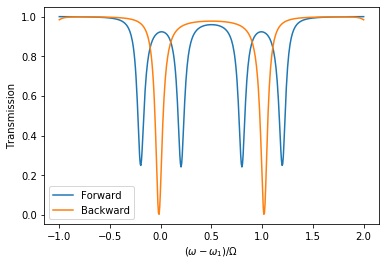

In [173]:
omegas = np.linspace(-1, 2, 501)
(_, s0_f, _) = shi_transmission(omegas, 0.02, 0.02, 0.02, 0.02, 0.2, matched=True)
(_, s0_b, _) = shi_transmission(omegas, 0.02, 0.02, 0.02, 0.02, 0.2, matched=False)
plot_f_b(omegas, s0_f, s0_b)

Compute forward and backward transmission using the theory from Jerry's paper for a Zongfu-like isolator.

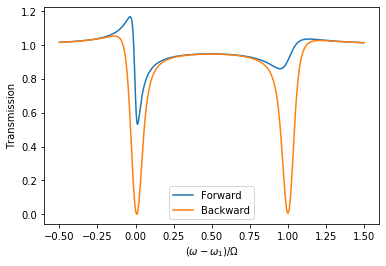

In [174]:
omegas = np.linspace(-0.5, 1.5, 501)

# Some parameters like in Zongfu's paper
gc1 = 0.02
gc2 = 0.08
gr1 = 0.002
gr2 = 0.002

# RWA critical condition in presence of loss for isolation at omega_1
J = np.sqrt(2*gc1*(gc2+gr2) - (gc1+gr1)*(gc2+gr2)) 

(_, s0_f, _) = shi_transmission(omegas, gc1, gc2, gr1, gr2, J, matched=False)
(_, s0_b, _) = shi_transmission(omegas, gc1, gc2, gr1, gr2, J, matched=True)
plot_f_b(omegas, s0_f, s0_b)

These results are unphysical (specifically, transmission > 1), due to the fact that Jerry's paper neglects the coupling through the environment. A better result can be obtained within RWA. This was derived by hand and does not explicitly appear in Zongfu's paper.

In [176]:
def yu_rwa(omegas, gc1, gc2, gr1, gr2, J, matched=True):
    """Implement CMT assuming RWA around omega_1 for the ring setup of
    Yu and Fan, Nature Photonics, 3 (2009).
    """
    # Total loss rates
    gt1 = gc1 + gr1 + 1e-20
    gt2 = gc2 + gr2 + 1e-20 
    
    if matched==True:
        s0 = 1 - 2*gc1*(1j*omegas + gt2)/ \
                ((1j*omegas + gt1)*(1j*omegas + gt2) + np.abs(J)**2)
    elif matched==False:
        s0 = 1 - 2*gc1/(1j*omegas + gt1)
        
    return s0

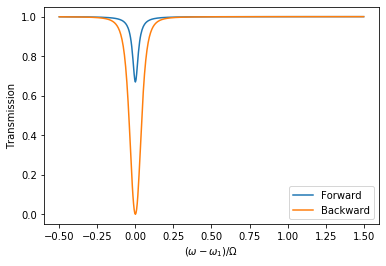

In [177]:
s0_f = yu_rwa(omegas, gc1, gc2, gr1, gr2, J, matched=False)
s0_b = yu_rwa(omegas, gc1, gc2, gr1, gr2, J, matched=True)
plot_f_b(omegas, s0_f, s0_b)

We can "fix" the result from Jerry's paper by including the coupling through the common radiation channel, which makes the Floquet system not separable. This means that a linear solve at every input $\omega$ is required. 

In [201]:
def shi_fixed(omegas, gc1, gc2, gr1, gr2, J, matched=True, p_trunc=5):
    """Implement the full CMT needed to describe the system of 
    Shi et al. IEEE JSTQE, 24 (2018), including the coupling through the 
    common radiation channel. 
    
    Parameters
    ----------
    omegas: NumPy array
        an array of monochromatic input frequencies over which the 
        transmission will be computed, centered at omega_1
    gc1, gc2: float
        coupling of the first and second mode to the waveguide in 
    gr1, gr2: float
        radiation losses of the first and second mode
    J: complex
        effective coupling constant between the modes due to the modulation
    matched: bool
        if True, the side-bands at omega_1 and omega_2 - Omega are 
        coupled (resonantly in the Floquet picture). If False, the modes at 
        omega_1 - Omega and omega_2 + Omega are coupled (non-resonantly).
        Note that matched=False would correspond to J=0 in RWA, but here
        a second-order effect is also included.
    p_trunc: int
        Floquet side-bands truncated to +/- p_trunc
        
    Returns
    -------
    sout: NumPy array
        Array of shape (2*p_trunc+1, omegas.size), giving the transmission
        spectrum at each side-band.
    """
    
    # Combined loss rates
    gt1 = gc1 + gr1 + 1e-20
    gt2 = gc2 + gr2 + 1e-20
    
    # Coupling terms to the waveguide
    k1 = 1j*np.sqrt(2*gc1)
    k2 = 1j*np.sqrt(2*gc2)
    
    # Mode coupling through the environment
    Je = np.sqrt(gc1*gc2)
    
    # Variable to collect the zero-side-band transmission spectrum
    sout = np.zeros((2*p_trunc+1, omegas.size), dtype=np.complex)
    
    for iom, omega in enumerate(omegas):
        # Floquet matrix construction
        oms = []
        Jes = [] # environment
        Jcs = [] # modulation

        for p in range(-p_trunc, p_trunc+1):
            oms.append(1j*(omega - p) + gt1)
            oms.append(1j*(omega - 1 - p) + gt2) # omega_2 = omega_1 + 1
            Jes += [Je, 0]
            Jcs += [0, J]
        oms = np.array(oms).ravel()
        
        # Diagonal frequency terms
        A = np.diag(oms, 0) 
        
        # Coupling through the common raditive channel enters as a non-Hermitian 
        # term, with the same prefactor as the loss rates gamma (so no 1j)     
        A += np.diag(Jes[:-1], 1) + np.diag(Jes[:-1], -1)
        
        # The modulation-driven coupling enters as a usual Hermitian term
        if matched==True:
            A += 1j*np.diag(Jcs[:-1], 1) + 1j*np.diag(np.conj(Jcs[:-1]), -1)
        elif matched==False:
            A += 1j*np.diag(Jcs[1:-2], 3) + 1j*np.diag(np.conj(Jcs[1:-2]), -3)   

        s_in = np.zeros((2*(2*p_trunc+1)), dtype=np.complex)
        s_in[2*p_trunc] = k1
        s_in[2*p_trunc+1] = k2
        
        # Amplitudes in each Floquet side-band of each mode
        amps = np.linalg.solve(A, s_in)
        
        s = np.zeros((2*p_trunc+1, ), dtype=np.complex)
        s[p_trunc] = 1
        s += k1*amps[0::2] + k2*amps[1::2]
        sout[:, iom] = s

    return sout

The result for the Zongfu isolator, which looked unphysical above, is fixed even when truncating the Floquet side-bands to $\pm 1$. The issue really came from the coupling through the common waveguide output. Notice also that the spectrum around $\omega_1$ matches very well the RWA result above, but now we have the complete picture.

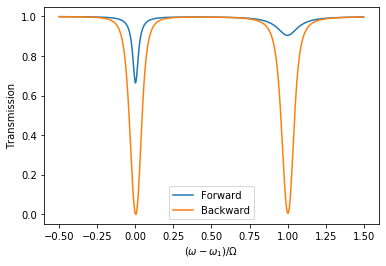

In [203]:
omegas = np.linspace(-0.5, 1.5, 501)
p_trunc = 1 
s0_f = shi_fixed(omegas, gc1, gc2, gr1, gr2, J, matched=False, p_trunc=p_trunc)[p_trunc, :]
s0_b = shi_fixed(omegas, gc1, gc2, gr1, gr2, J, matched=True, p_trunc=p_trunc)[p_trunc, :]
plot_f_b(omegas, s0_f, s0_b)

The results for the Jerry-type isolator do not visibly change when using the fixed version.

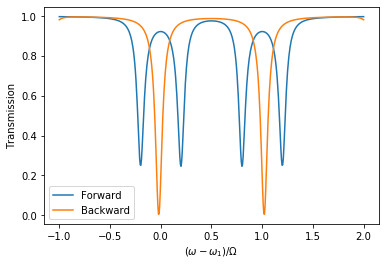

In [205]:
omegas = np.linspace(-1, 2, 501)
s0_f = shi_fixed(omegas, 0.02, 0.02, 0.02, 0.02, 0.2, matched=True, p_trunc=p_trunc)[p_trunc, :]
s0_b = shi_fixed(omegas, 0.02, 0.02, 0.02, 0.02, 0.2, matched=False, p_trunc=p_trunc)[p_trunc, :]
plot_f_b(omegas, s0_f, s0_b)